[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1r2nCePzEdYImxJl9qpciuRqjdTOYmMys?usp=sharing)

##1. Simple Image Classification

In [2]:
!pip install --quiet keras-nightly keras-hub-nightly tensorflow-datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 24.0 MB/s eta 0:00:00


In [3]:
import os

In [4]:
# Configure backend (can be 'jax', 'torch', or 'tensorflow')
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [5]:
# Imports
import keras
import keras_hub
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import random

In [6]:
#  Load CIFAR-10 Dataset
(raw_train, raw_test), meta = tfds.load(
    "cifar10",
    split=["train[:1000]", "test[:200]"],  # Faster training dataset
    as_supervised=True,
    with_info=True,
    batch_size=-1
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.6BJ7U8_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.6BJ7U8_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [7]:
# Preprocess Function
def format_data(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return tf.cast(image, tf.float32), label

In [8]:
# Process dataset using .map
BATCH_SIZE = 32  # Larger batch → fewer steps per epoch
train_ds = tf.data.Dataset.from_tensor_slices((raw_train[0], raw_train[1])).map(format_data).shuffle(300).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((raw_test[0], raw_test[1])).map(format_data).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [9]:
#  Load Base Model from Keras Hub (ResNet50 pretrained on ImageNet)
resnet_base = keras_hub.models.ImageClassifier.from_preset("resnet_50_imagenet", activation=None)

In [10]:
# Define Transfer Learning Model
inputs = keras.Input(shape=(224, 224, 3))
x = resnet_base.backbone(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [11]:
# Compile Model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [12]:
#  Train the Model
history = model.fit(train_ds, epochs=3, validation_data=test_ds)

Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.2428 - loss: 2.0952 - val_accuracy: 0.5600 - val_loss: 1.2066
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - accuracy: 0.7236 - loss: 0.8888 - val_accuracy: 0.7000 - val_loss: 0.8060
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.8935 - loss: 0.3629 - val_accuracy: 0.7300 - val_loss: 0.7712


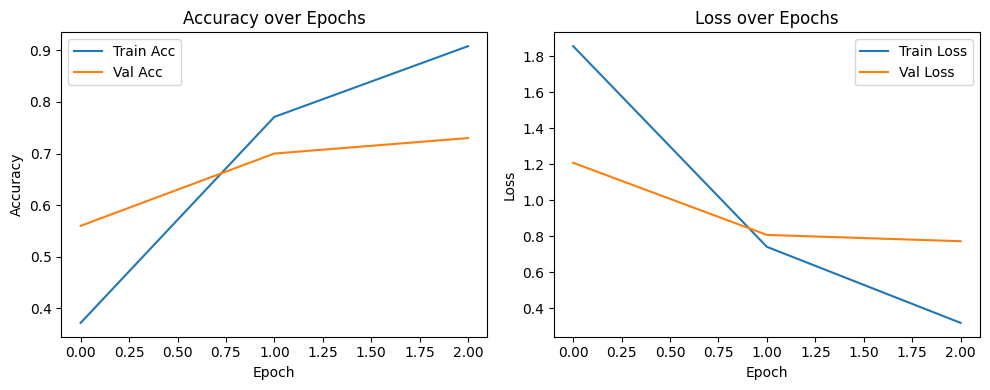

In [17]:
#  Accuracy Plot
plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


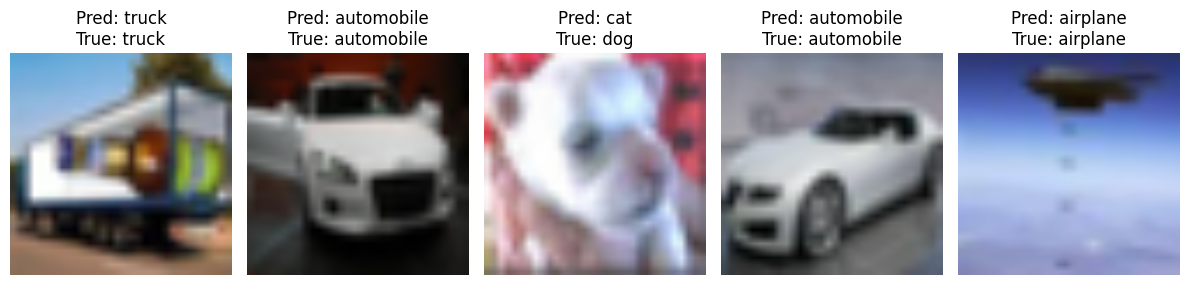

In [18]:
# Show predictions from a random batch
total_batches = int(200 / BATCH_SIZE)
batch_index = random.randint(0, total_batches - 1)

# Grab the batch
batch_images, batch_labels = next(iter(test_ds.skip(batch_index).take(1)))
predictions = model.predict(batch_images[:5])
predicted_labels = np.argmax(predictions, axis=1)

#  Display results
class_names = meta.features['label'].names
plt.figure(figsize=(12, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch_images[i].numpy())
    plt.title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {class_names[batch_labels[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

##2. Intermediate Image Classification

In [19]:
!pip uninstall -y keras keras-nightly keras-hub-nightly efficientnet segmentation-models -q
!pip install --quiet tensorflow keras

# 🔧 Imports
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.4 MB/s eta 0:00:00


In [20]:
def build_unet(input_size=(128, 128, 3), n_classes=3):
    inputs = layers.Input(shape=input_size)

    # Encoder blocks
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D()(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D()(conv2)

    # Bottleneck
    bottleneck = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    bottleneck = layers.Conv2D(256, 3, activation='relu', padding='same')(bottleneck)

    # Decoder blocks
    up1 = layers.UpSampling2D()(bottleneck)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)

    up2 = layers.UpSampling2D()(conv3)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv4)

    outputs = layers.Conv2D(n_classes, 1)(conv4)  # No activation

    return Model(inputs, outputs)

In [21]:
#  Create and compile model
unet = build_unet()
unet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

#  Show architecture
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 3)    │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,698,947 (6.48 MB)

 Trainable params: 1,698,947 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Load dataset with segmentation masks
(train_raw, test_raw), info = tfds.load(
    "oxford_iiit_pet",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=False,
    with_info=True
)

# Resize and normalize image + clip mask labels
def process_sample(example):
    img = tf.image.resize(example["image"], (128, 128)) / 255.0
    mask = tf.image.resize(example["segmentation_mask"], (128, 128), method='nearest')
    mask = tf.cast(mask, tf.int32)
    mask = tf.clip_by_value(mask, 0, 2)  # Keep class labels in 0–2
    return img, mask

# Apply map + batching
train_ds = train_raw.map(process_sample).batch(16).prefetch(tf.data.AUTOTUNE)
test_ds = test_raw.map(process_sample).batch(16).prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.S4WVE2_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.S4WVE2_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [23]:
# Fit the model
history = unet.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 48s 162ms/step - accuracy: 0.6934 - loss: 0.6857 - val_accuracy: 0.7175 - val_loss: 0.4967
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.7410 - loss: 0.4843 - val_accuracy: 0.7507 - val_loss: 0.4829
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - accuracy: 0.7647 - loss: 0.4617 - val_accuracy: 0.7432 - val_loss: 0.4985
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 38s 118ms/step - accuracy: 0.7869 - loss: 0.4357 - val_accuracy: 0.8108 - val_loss: 0.4060
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.8124 - loss: 0.4004 - val_accuracy: 0.8189 - val_loss: 0.3890


In [26]:
def show_predictions(model, dataset, count=5):
    # Calculate how many batches exist
    batch_size = 16
    total_images = 366  # Oxford-IIIT Pet test size is approx 20% of 3680
    max_batches = total_images // batch_size

    # Pick a random batch index
    skip_batches = random.randint(0, max_batches - 1)

    # Fetch one random batch
    random_batch = dataset.skip(skip_batches).take(1)
    sample_images, true_masks = next(iter(random_batch))

    # Generate model predictions
    logits = model.predict(sample_images)
    pred_masks = tf.argmax(logits, axis=-1)
    true_masks = tf.squeeze(true_masks, axis=-1)

    # Plot predictions vs ground truth
    plt.figure(figsize=(12, count * 3))
    for i in range(count):
        plt.subplot(count, 3, i * 3 + 1)
        plt.imshow(sample_images[i])
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(count, 3, i * 3 + 2)
        plt.imshow(true_masks[i], cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(count, 3, i * 3 + 3)
        plt.imshow(pred_masks[i], cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


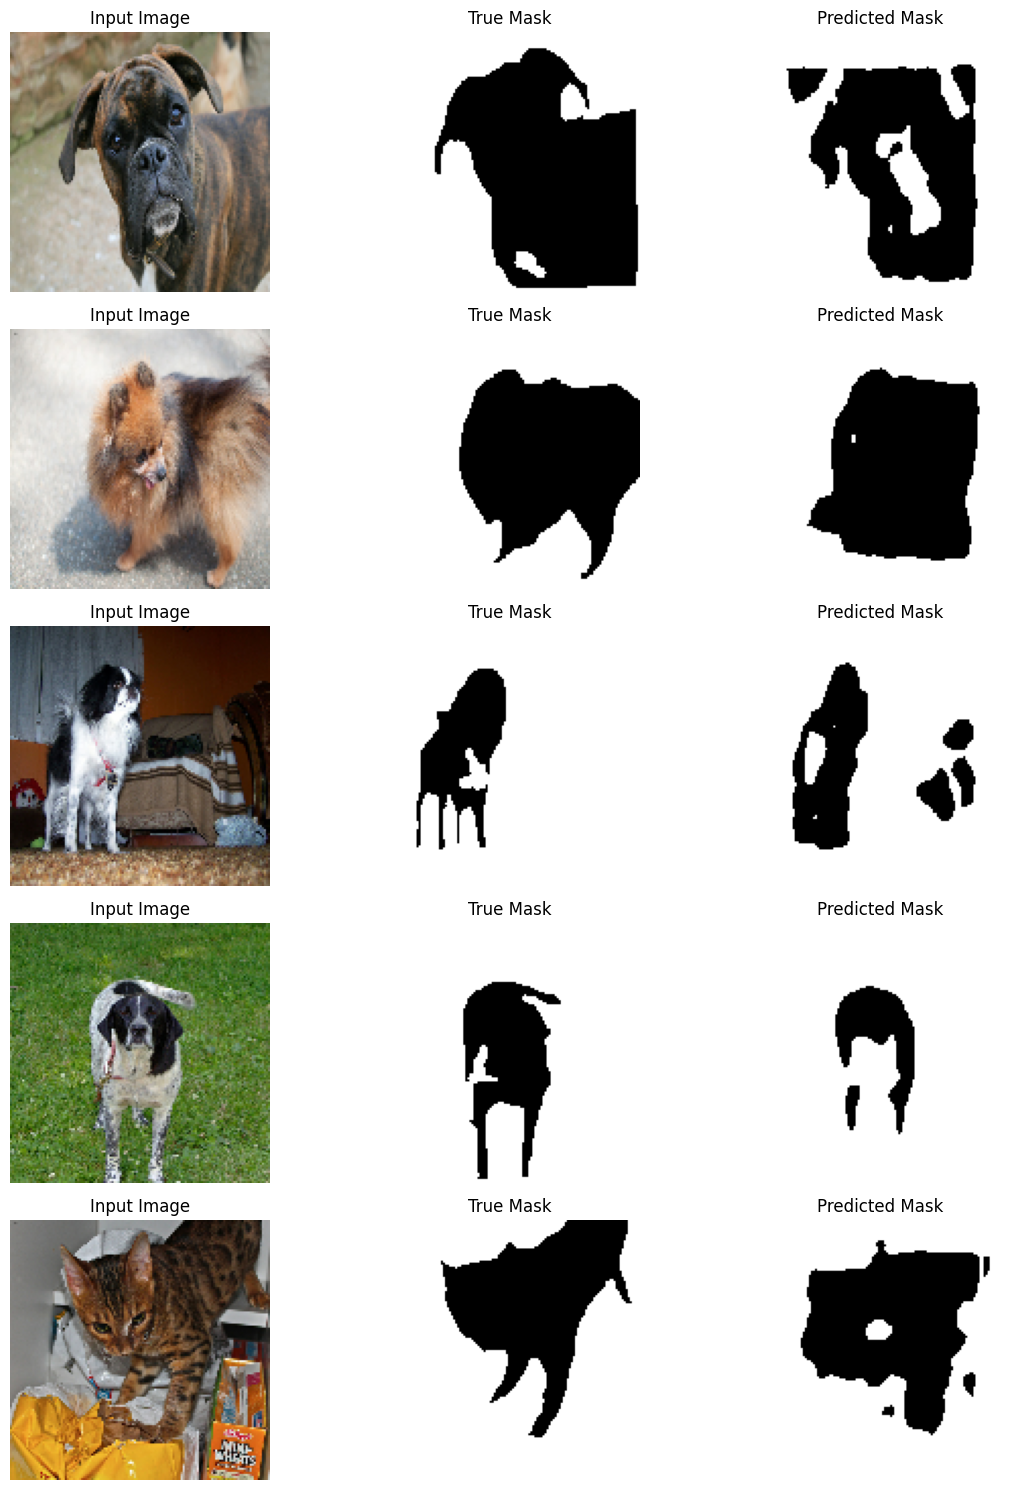

In [27]:
# Display predictions on test data
show_predictions(unet, test_ds, count=5)

## Advance Image Classification

In [28]:
# Install required packages
!pip install --quiet tensorflow numpy matplotlib

In [29]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import random

In [30]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize images to [0, 1]
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# One-hot encode labels
train_labels_cat = to_categorical(train_labels, 10)
test_labels_cat = to_categorical(test_labels, 10)

# 🏷️ Class labels for display
labels = ["Airplane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


<ipython-input-31-d8579105d3fc>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(labels[int(train_labels[idx])])


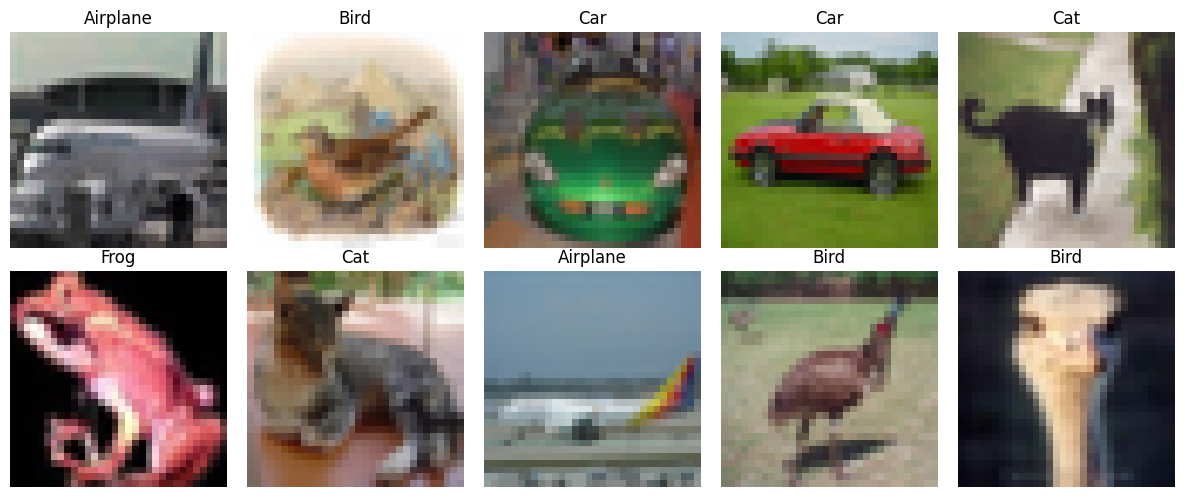

In [31]:
# Display 10 random training images
plt.figure(figsize=(12, 5))
rand_indices = random.sample(range(len(train_images)), 10)
for i, idx in enumerate(rand_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[idx])
    plt.title(labels[int(train_labels[idx])])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [32]:
# Build a sequential CNN
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
# Compile the model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# View model architecture
cnn_model.summary()

# Train the model
training_history = cnn_model.fit(
    train_images, train_labels_cat,
    validation_data=(test_images, test_labels_cat),
    epochs=10,
    batch_size=64
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,706 (1.36 MB)

 Trainable params: 357,258 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.3272 - loss: 1.9168 - val_accuracy: 0.5248 - val_loss: 1.3640
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5493 - loss: 1.2713 - val_accuracy: 0.6126 - val_loss: 1.1179
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6338 - loss: 1.0504 - val_accuracy: 0.6959 - val_loss: 0.8792
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6829 - loss: 0.9058 - val_accuracy: 0.7045 - val_loss: 0.8357
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7162 - loss: 0.8190 - val_accuracy: 0.7114 - val_loss: 0.8268
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7425 - loss: 0.7455 - val_accuracy: 0.7194 - val_loss: 0.8125
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7705 - loss: 0.6640 - val_accuracy: 0.7287 - val_loss: 0.8061
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7869 - loss: 0.6127 - val_accuracy: 

In [34]:
# Evaluate final performance
loss, accuracy = cnn_model.evaluate(test_images, test_labels_cat)
print(f"\n Final Test Accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7264 - loss: 0.8610

✅ Final Test Accuracy: 0.7231


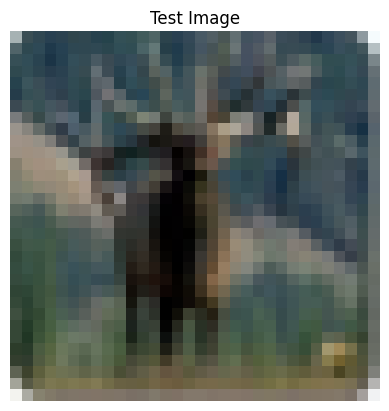

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
🎯 Predicted Class: Deer (True: Deer)


<ipython-input-35-97e96a559ec5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"🎯 Predicted Class: {predicted_class} (True: {labels[int(test_labels[index])]})")


In [35]:
def predict_random_test_image():
    index = random.randint(0, len(test_images) - 1)
    img = test_images[index]

    # Display the image
    plt.imshow(img)
    plt.title("Test Image")
    plt.axis("off")
    plt.show()

    # Expand dimension and predict
    input_img = np.expand_dims(img, axis=0)
    prediction = cnn_model.predict(input_img)
    predicted_class = labels[np.argmax(prediction)]

    print(f"Predicted Class: {predicted_class} (True: {labels[int(test_labels[index])]})")

# 🔎 Predict a random image
predict_random_test_image()

## Expert: Image Classification

In [36]:
# Install dependencies
!pip install --quiet tensorflow tensorflow_hub tensorflow_datasets seaborn

In [37]:

# Import required libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [38]:
# Load dataset splits
(train_raw, val_raw), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:85%]', 'train[85%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True
)

IMG_DIM = (224, 224)
CLASSES = ds_info.features['label'].num_classes
BATCH_SIZE = 32

# Augmentation
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

# Preprocess: add brightness/contrast as meta features
def process_sample(image, label):
    image = tf.image.resize(image, IMG_DIM) / 255.0
    image = augment(image)

    brightness = tf.reduce_mean(image)
    contrast = tf.image.total_variation(image)
    meta_features = tf.concat([tf.reshape(brightness, [1]), tf.reshape(contrast, [1])], axis=0)

    return (image, meta_features), label

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.YPFZTA_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [39]:

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_raw.map(process_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_raw.map(process_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [40]:
def create_meta_model():
    # Inputs
    image_in = tf.keras.Input(shape=(224, 224, 3), name="image_input")
    meta_in = tf.keras.Input(shape=(2,), name="meta_input")

    # Pretrained backbone
    base = tf.keras.applications.MobileNetV2(input_tensor=image_in, include_top=False, weights='imagenet')
    base.trainable = True
    for layer in base.layers[:-20]:
        layer.trainable = False

    # Visual branch
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Meta branch
    meta_x = tf.keras.layers.Dense(32, activation='relu')(meta_in)

    # Combine both
    combined = tf.keras.layers.Concatenate()([x, meta_x])
    combined = tf.keras.layers.Dense(64, activation='relu')(combined)
    combined = tf.keras.layers.Dropout(0.4)(combined)
    output = tf.keras.layers.Dense(CLASSES, activation='softmax')(combined)

    return tf.keras.Model(inputs=[image_in, meta_in], outputs=output)

model = create_meta_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

<ipython-input-40-cf01fb51b33f>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(input_tensor=image_in, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,433,189 (9.28 MB)

 Trainable params: 1,381,029 (5.27 MB)

 Non-trainable params: 1,052,160 (4.01 MB)

In [41]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.3)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 100s 800ms/step - accuracy: 0.2104 - loss: 391.0616 - val_accuracy: 0.6582 - val_loss: 3.5423 - learning_rate: 0.0010
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 105s 545ms/step - accuracy: 0.5096 - loss: 2.5875 - val_accuracy: 0.6673 - val_loss: 0.9622 - learning_rate: 0.0010
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 74s 461ms/step - accuracy: 0.5596 - loss: 1.0634 - val_accuracy: 0.7582 - val_loss: 0.7895 - learning_rate: 0.0010
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 416ms/step - accuracy: 0.6409 - loss: 0.9029 - val_accuracy: 0.7018 - val_loss: 0.7213 - learning_rate: 0.0010
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 412ms/step - accuracy: 0.6510 - loss: 0.8319 - val_accuracy: 0.8582 - val_loss: 0.6058 - learning_rate: 0.0010
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 44s 452ms/step - accuracy: 0.6302 - loss: 0.8414 - val_accuracy: 0.7673 - val_loss: 0.5796 - learning_rate: 0.0010
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 40s 411ms/step - accuracy: 0.6732 - loss

In [42]:
val_loss, val_acc = model.evaluate(val_ds)
print(f" Validation Accuracy: {val_acc:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.8626 - loss: 0.4861
 Validation Accuracy: 0.8818


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


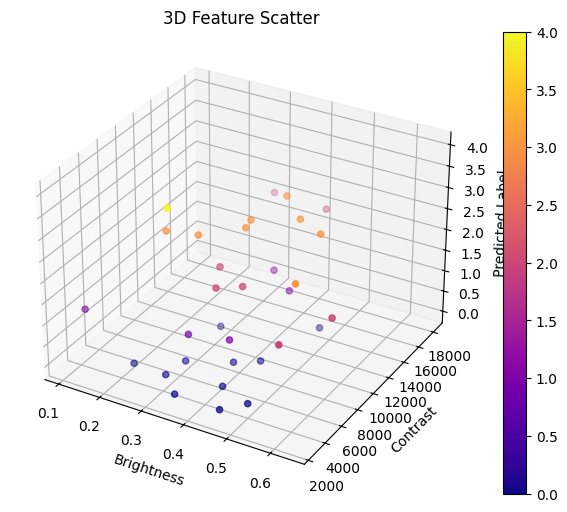

In [43]:
def show_3d_scatter(model, dataset, title="3D Feature Scatter"):
    for (images, metas), _ in dataset.take(1):
        predictions = model.predict([images, metas])
        predicted_classes = np.argmax(predictions, axis=1)

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(metas[:, 0], metas[:, 1], predicted_classes, c=predicted_classes, cmap="plasma")
        ax.set_xlabel("Brightness")
        ax.set_ylabel("Contrast")
        ax.set_zlabel("Predicted Label")
        plt.title(title)
        plt.colorbar(scatter)
        plt.show()

show_3d_scatter(model, val_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


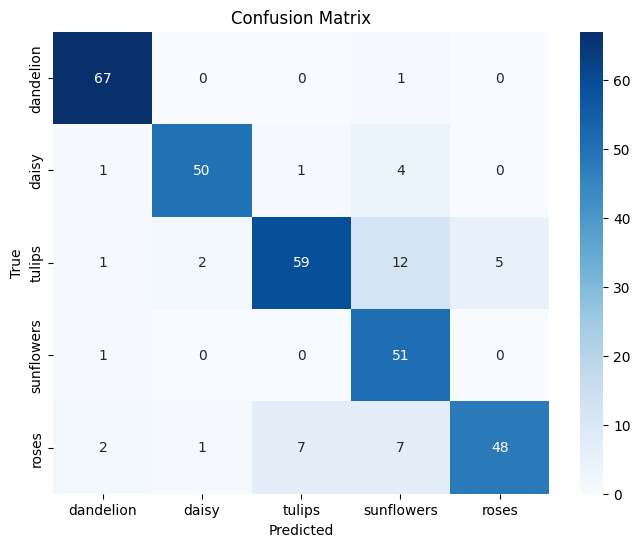

 Classification Report:

              precision    recall  f1-score   support

   dandelion       0.93      0.99      0.96        68
       daisy       0.94      0.89      0.92        56
      tulips       0.88      0.75      0.81        79
  sunflowers       0.68      0.98      0.80        52
       roses       0.91      0.74      0.81        65

    accuracy                           0.86       320
   macro avg       0.87      0.87      0.86       320
weighted avg       0.87      0.86      0.86       320



In [44]:
true_vals, pred_vals = [], []
flower_labels = ds_info.features['label'].names

for (images, metas), labels in val_ds.take(10):
    predictions = model.predict([images, metas])
    true_vals.extend(labels.numpy())
    pred_vals.extend(np.argmax(predictions, axis=1))

# Confusion matrix
cm = confusion_matrix(true_vals, pred_vals)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=flower_labels, yticklabels=flower_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(" Classification Report:\n")
print(classification_report(true_vals, pred_vals, target_names=flower_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


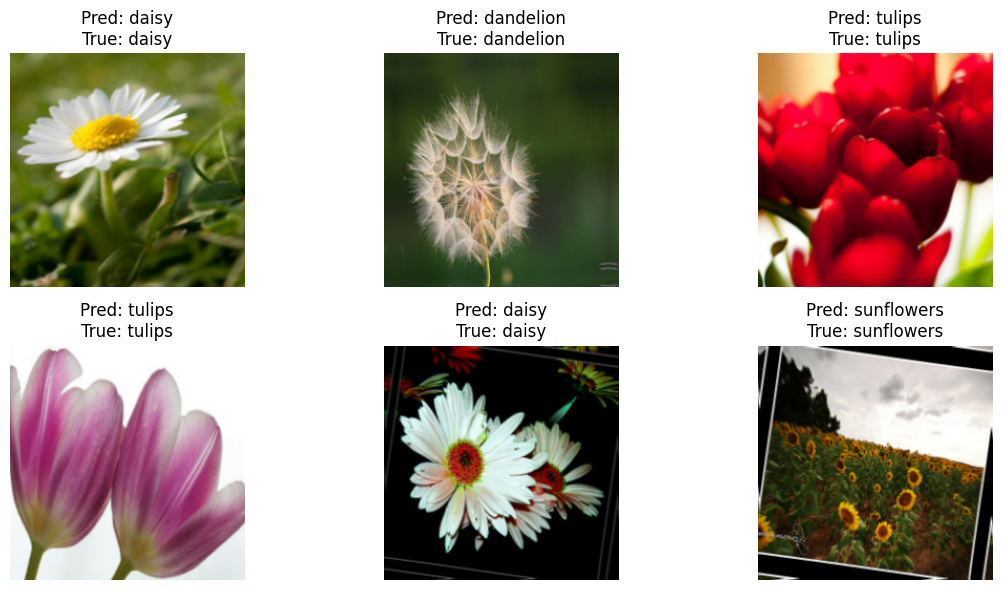

In [45]:
def visualize_random_predictions(model, dataset, count=6):
    for (images, metas), labels in dataset.shuffle(100).take(1):
        preds = model.predict([images, metas])
        predicted_classes = np.argmax(preds, axis=1)

        plt.figure(figsize=(12, 6))
        for i in range(count):
            plt.subplot(2, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"Pred: {flower_labels[predicted_classes[i]]}\nTrue: {flower_labels[labels[i]]}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

visualize_random_predictions(model, val_ds)